<a href="https://colab.research.google.com/github/chetan009-sjce/-AI-German-to-english/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Bidirectional,RepeatVector,TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth',200)

In [ ]:
#fuction to read file
def read_txt(filename):
  file=open(filename,mode='rt',encoding='utf-8')
  text=file.read()
  file.close()
  return text

In [ ]:
#split the sentences
def to_lines(text):
  sents=text.strip().split('\n')
  sents=[i.split('\t') for i in sents]
  return sents

In [ ]:
#converting data to array
data=read_txt("deu.txt")
deu_eng=to_lines(data)
deu_eng=array(deu_eng)

In [ ]:
#using first 50000 sentence pairs
deu_eng=deu_eng[:30000,:]

In [ ]:
#lets look at data
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Today is a holiday.', 'Heute ist ein Feiertag.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1345341 (tboronczyk) & #745895 (MUIRIEL)'],
       ['Today is a hot day.', 'Heute ist ein heißer Tag.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #882659 (CM) & #905628 (Esperantostern)'],
       ['Tom abandoned hope.', 'Tom hat die Hoffnung aufgegeben.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3436596 (CK) & #3612314 (Jan_Schreiber)']],
      dtype='<U120')

In [ ]:
#empty lists
#text to sequence conversion
eng_l=[]
deu_l=[]
#populate lists with sentence lengths
for i in deu_eng[:,0]:
  eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_l.append(len(i.split()))


In [ ]:
length_df=pd.DataFrame({'eng':eng_l,'deu':deu_l})

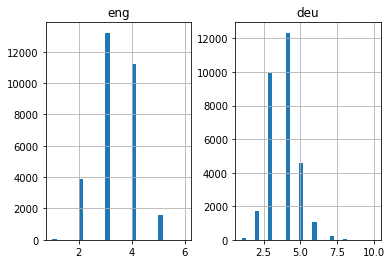

In [ ]:
length_df.hist(bins=30)
plt.show()

In [ ]:
#function to build tokenixer
def tokenization(lines):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
#prepare english tokenizer
eng_tokenizer=tokenization(deu_eng[:,0])
eng_vocab_size=len(eng_tokenizer.word_index)+1
eng_length=8
print('English Vocabilary Size: %d' % eng_vocab_size)

English Vocabilary Size: 4691


In [ ]:
#prepare deutch tokenizer
deu_tokenizer=tokenization(deu_eng[:,1])
deu_vocab_size=len(deu_tokenizer.word_index)+1
deu_length=8
print('Deutch Vocabulary Size is %d' % deu_vocab_size)

Deutch Vocabulary Size is 7460


In [ ]:
#encode and pad sequences
def encode_sequences(tokenizer,length,lines):
  #integer encode sequences
  seq=tokenizer.texts_to_sequences(lines)
  #pad sequences with 0 values
  seq=pad_sequences(seq,maxlen=length, padding='post')
  return seq

In [ ]:
#split data to train and test
from sklearn.model_selection import train_test_split
train,test=train_test_split(deu_eng,test_size=0.2,random_state=12)

In [ ]:
#encode sentences we use german sent as input seq and eng seq as target seq for both traain and test

In [ ]:
trainX=encode_sequences(deu_tokenizer,deu_length,train[:,1])
trainY=encode_sequences(eng_tokenizer,eng_length,train[:,0])

In [ ]:
testX=encode_sequences(deu_tokenizer,deu_length,test[:,1])
testY=encode_sequences(eng_tokenizer,eng_length,test[:,0])

In [ ]:
#defining seq2seq model arch we are using an embedding layeer and as LSTM layer as encoder and another LSTM layer followed by dense layer as decoder
#bild NMT(neural machine translation )model 
def build_model(in_vocab,out_vocab,in_timesteps,out_timesteps,units):
  model=Sequential()
  model.add(Embedding(in_vocab,units,input_length=in_timesteps,mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units,return_sequences=True))
  model.add(Dense(out_vocab,activation='softmax'))
  return model
  

In [ ]:
#using Rms prop optimizer it is good of recuurnt nerual networks
model=build_model(deu_vocab_size,eng_vocab_size,deu_length,eng_length,512)
rms=optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms,loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#we will train for 30 epochs and with batch size 512 hyperparametrs we use modelcheckpoint to save model with low validation loss

filename='model.Suhas'
checkpoint=ModelCheckpoint(filename,monitor='val_loss',verbose=1,save_best_only=True,mode='min')
history=model.fit(trainX,trainY.reshape(trainY.shape[0],trainY.shape[1],1),
        epochs=3,batch_size=512,
        validation_split=0.2,
        callbacks=[checkpoint], verbose=1)

Epoch 1/3
38/38 [==============================] - 126s 3s/step - loss: 2.7077 - val_loss: 2.5374

Epoch 00001: val_loss improved from inf to 2.53736, saving model to model.Suhas


INFO:tensorflow:Assets written to: model.Suhas/assets


INFO:tensorflow:Assets written to: model.Suhas/assets


Epoch 2/3
38/38 [==============================] - 127s 3s/step - loss: 2.5071 - val_loss: 2.4925

Epoch 00002: val_loss improved from 2.53736 to 2.49251, saving model to model.Suhas


INFO:tensorflow:Assets written to: model.Suhas/assets


INFO:tensorflow:Assets written to: model.Suhas/assets


Epoch 3/3
38/38 [==============================] - 125s 3s/step - loss: 2.4164 - val_loss: 2.3987

Epoch 00003: val_loss improved from 2.49251 to 2.39867, saving model to model.Suhas


INFO:tensorflow:Assets written to: model.Suhas/assets


INFO:tensorflow:Assets written to: model.Suhas/assets


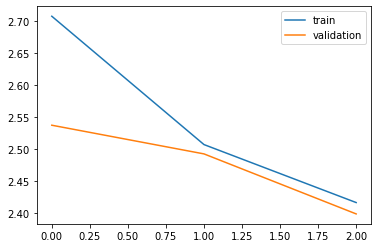

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:

model=load_model('model.Suhas')
preds=model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def get_word(n,tokenizer):
  for word, index in tokenizer.word_index.items():
    if index==n:
      return word
  return None    

In [ ]:
preds_text=[]
for i in preds:
  temp=[]
  for j in range(len(i)):
    t=get_word(i[j],eng_tokenizer)
    if j>0:
      if (t==get_word(i[j-1],eng_tokenizer)) or (t==None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if (t==None):
        temp.append('')
      else:
        temp.append(t)


    preds_text.append(' '.join(temp))

In [ ]:
a={'actual':test[:,0], 'predicted': preds_text}
pred_df=pd.DataFrame.from_dict(a,orient='index')


pred_df=pred_df.transpose()

In [ ]:
pd.set_option('display.max_colwidth',200)

In [ ]:
pred_df.head(15)

,actual,predicted
0,Aren't you happy?,tom
1,Are you prepared?,tom is
2,Come on in here.,tom is
3,She deserved it.,tom is
4,I need a hammer.,tom is
5,It's early.,tom is
6,Don't believe Tom.,tom is
7,I don't have a job.,tom is
8,Are you done now?,tom
9,I wrote that.,tom is
